# Create UMAP of single cell features

In [1]:
from livecellx.sample_data import tutorial_three_image_sys

dic_dataset, mask_dataset = tutorial_three_image_sys(dic_dataset_path="../datasets/test_data_STAV-A549/DIC_data", mask_dataset_path="../datasets/test_data_STAV-A549/mask_data")

|-----> Downloading data to datasets/test_data_STAV-A549.zip
|-----> [download] in progress: 100.0000%
|-----> [download] finished [1.9398s]
|-----> Extracting data to datasets
3 png img file paths loaded;
3 tif img file paths loaded;


In [2]:
from livecellx.core.io_sc import prep_scs_from_mask_dataset
scs = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


In [3]:
from livecellx.trajectory.feature_extractors import compute_haralick_features, compute_skimage_regionprops
from livecellx.preprocess.utils import normalize_img_to_uint8
for sc in scs:
    features = compute_skimage_regionprops(sc, preprocess_img_func=normalize_img_to_uint8, sc_level_normalize=True)

In [4]:
sc.get_feature_pd_series()

skimage_area                 22262.000000
skimage_area_bbox            39672.000000
skimage_area_convex          23414.000000
skimage_area_filled          22262.000000
skimage_axis_major_length      263.397536
                                 ...     
skimage_orientation             -1.053940
skimage_perimeter              660.825469
skimage_perimeter_crofton      629.183347
skimage_solidity                 0.950799
t                                2.000000
Length: 144, dtype: float64

In [5]:
def create_sc_table(scs, normalize_features=True):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame([sc.get_feature_pd_series() for sc in scs])
    if normalize_features:
        for col in df.columns:
            df[col] = (df[col] - df[col].mean())
            col_std = df[col].std()
            if col_std != 0 and not np.isnan(col_std):
                df[col] /= col_std
    # remove column t from df
    df.drop("t", axis=1, inplace=True)
    # df["sc_id"] = [sc.id for sc in scs]
    # df["t"] = [sc.timeframe for sc in scs]
    # df.set_index("sc_id", inplace=True)
    return df

sc_feature_table = create_sc_table(scs)
sc_feature_table[:2]

,skimage_area,skimage_area_bbox,skimage_area_convex,skimage_area_filled,skimage_axis_major_length,skimage_axis_minor_length,skimage_centroid-0,skimage_centroid-1,skimage_centroid_local-0,skimage_centroid_local-1,...,skimage_moments_weighted_normalized-2-2,skimage_moments_weighted_normalized-2-3,skimage_moments_weighted_normalized-3-0,skimage_moments_weighted_normalized-3-1,skimage_moments_weighted_normalized-3-2,skimage_moments_weighted_normalized-3-3,skimage_orientation,skimage_perimeter,skimage_perimeter_crofton,skimage_solidity
0,-0.923369,-0.841766,-0.912960,-0.923369,-0.916872,-1.122806,-1.053760,-0.986053,-1.053760,-0.986053,...,1.480066,1.525486,-0.464037,1.143607,0.417709,1.349694,0.243301,-1.052502,-1.052564,-0.103188
1,0.560820,1.419363,0.582566,0.560820,1.770364,-0.567578,1.156528,1.266994,1.156528,1.266994,...,2.468260,3.998394,-0.358500,1.240825,2.761458,2.519574,0.519974,1.389685,1.386110,-1.041410


## Normalize features

## Perform UMAP on features

In [6]:
import umap
reducer = umap.UMAP()

/home/ken67/anaconda3/envs/livecell/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ken67/anaconda3/envs/livecell/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ken67/anaconda3/envs/livecell/lib/python3.10/site-packages/uma

In [7]:
# check if any columns are all NaN
sc_feature_table = sc_feature_table.dropna(axis=1, how="all")

In [8]:
embedding = reducer.fit_transform(sc_feature_table)

In [9]:
embedding.shape

(42, 2)

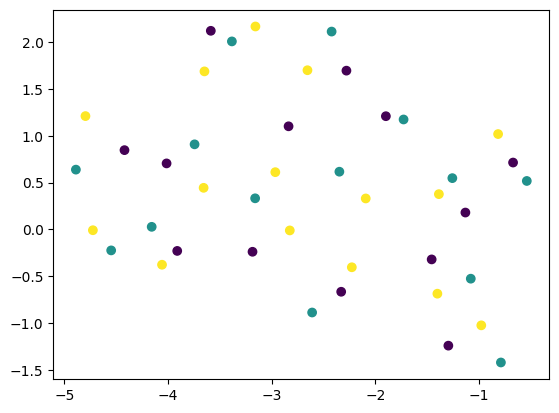

In [25]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sc.timeframe for sc in scs],
)

In [37]:
import numpy as np
import pandas as pd
# calculate correlation matrix between features and UMAP axis

umap_axis = embedding[:, 0]

low_dims = embedding

def compute_dims_corr(reduced_dims: np.array, sc_feature_table: pd.DataFrame):
    feature_cols = sc_feature_table.columns
    feature_corr_df = pd.DataFrame()
    for feature in feature_cols:
        for dim in range(reduced_dims.shape[1]):
            _embedding = reduced_dims[:, dim]
            corr = np.corrcoef(sc_feature_table[feature], _embedding)[0, 1]
            new_df = pd.DataFrame({"feature": [feature], "corr": [corr], "dim": [dim]})
            feature_corr_df = pd.concat([feature_corr_df, new_df], ignore_index=True)
    return feature_corr_df

In [ ]:
# sort by correlation absolute value
# feature_corr_df = feature_corr_df.reindex(feature_corr_df["corr"].abs().sort_values(ascending=False).index)
# feature_corr_df[:-5]

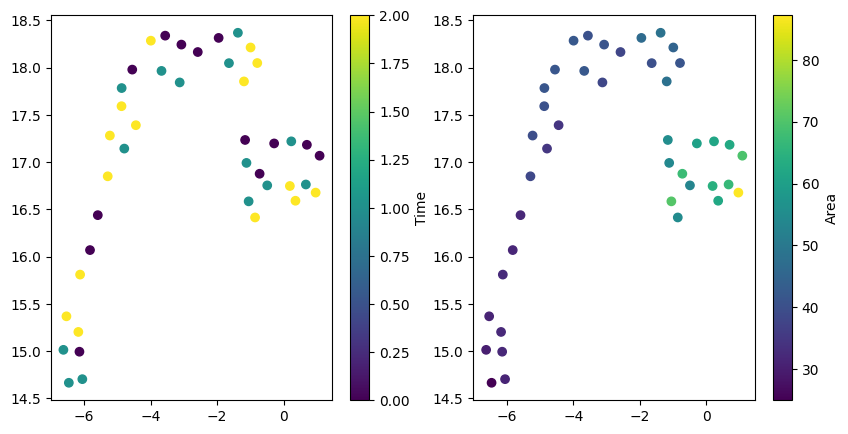

In [45]:
unnormalized_img_features = create_sc_table(scs, normalize_features=False)
# drop na
unnormalized_img_features = unnormalized_img_features.dropna(axis=1, how="all")
reducer = umap.UMAP()
unnormalized_embedding = reducer.fit_transform(unnormalized_img_features)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
scatter_time = axes[0].scatter(
    unnormalized_embedding[:, 0],
    unnormalized_embedding[:, 1],
    c=[sc.timeframe for sc in scs],
)
colorbar = fig.colorbar(scatter_time, ax=axes[0], label="Time")

scatter_area = axes[1].scatter(
    unnormalized_embedding[:, 0],
    unnormalized_embedding[:, 1],
    c=unnormalized_img_features["skimage_centroid_weighted_local-0"],
)
colorbar = fig.colorbar(scatter_area, ax=axes[1], label="Area")


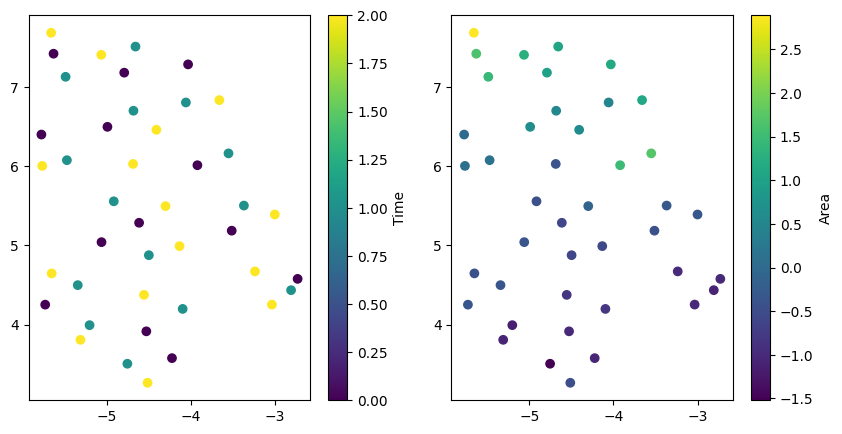

In [44]:
normalized_img_features = create_sc_table(scs, normalize_features=True)
# drop na
normalized_img_features = normalized_img_features.dropna(axis=1, how="all")
reducer = umap.UMAP()
normalized_embedding = reducer.fit_transform(normalized_img_features)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
scatter_time = axes[0].scatter(
    normalized_embedding[:, 0],
    normalized_embedding[:, 1],
    c=[sc.timeframe for sc in scs],
)
colorbar = fig.colorbar(scatter_time, ax=axes[0], label="Time")

scatter_area = axes[1].scatter(
    normalized_embedding[:, 0],
    normalized_embedding[:, 1],
    c=normalized_img_features["skimage_centroid_weighted_local-0"],
)
colorbar = fig.colorbar(scatter_area, ax=axes[1], label="Area")
